In [4]:
%%capture 
!python3 -m pip install google.cloud
!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install pyarrow

In [17]:
%matplotlib inline

import sqlite3
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import pyarrow
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import random

In [18]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)


conn = sqlite3.connect("Chinook_Sqlite.sqlite")
cursor = conn.cursor()



In [19]:
query = """
SELECT *
FROM ironhacks_covid19_competition.covid19_cases
"""
query_job = bigquery_client.query(query)
cases = query_job.to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [20]:

query = """
SELECT *
FROM ironhacks_covid19_competition.weekly_patterns
"""
query_job = bigquery_client.query(query)
df = query_job.to_dataframe()



# Overall Visulizations
Let's look at some data in the big picture and find some obvious trend in the overall data.
### Weekly New COVID-19 Cases
The graph below is the number of cumulative covid cases for each week, it has an exponential curve overall. Though I find the number of cases to be very high and I wonder if the data is correct. The total Tippecanoe population in 195,732

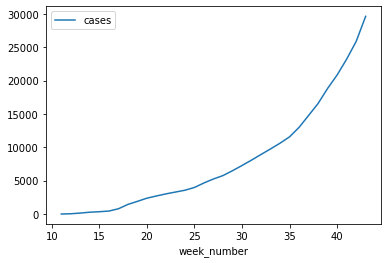

In [21]:
cases.plot('week_number','cases');

### Weekly Visits Trend
The graph below is a graph for number of total visits to all places for each week. We can see that the total number of visits made started to incrase exponentially starting form week 30 all the way to week 33 and drops after that. I looked up the data and week 33 is the week that Purdue starts. My explaination for the peak is that student started to come back since week 30 and went to places because the school hasn't started yet and most students were on campus around week 33. After the school has started, the students had less time to go out due to school work.

Text(0, 0.5, 'Total Raw Visit Counts')

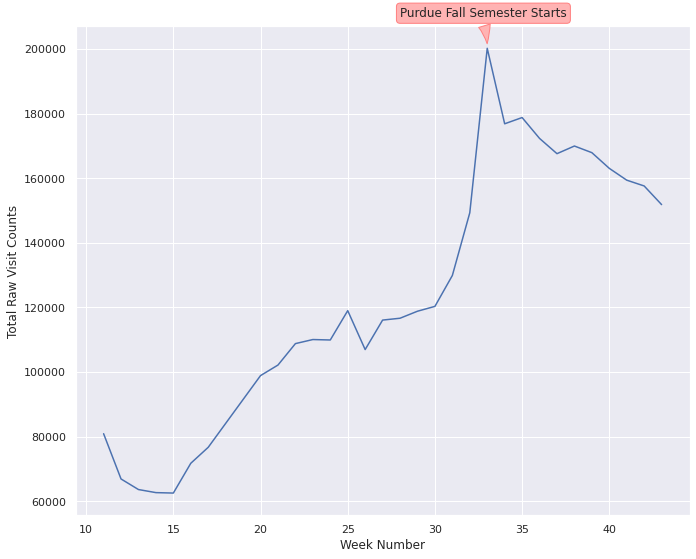

In [39]:
total = df.groupby('week_number')['raw_visit_counts'].sum()
plt.plot(total.index, total.values)
# plt.legend(bbox_to_anchor=(1, 0.2), bbox_transform=ax.transAxes)
plt.annotate("Purdue Fall Semester Starts", xy = (33, 201000), xytext = (28, 210000), 
            bbox=dict(boxstyle="round",  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5)),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.", connectionstyle="arc3,rad=-0.7", fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),relpos=(0.2, 0.8)))
plt.xlabel('Week Number')
plt.ylabel('Total Raw Visit Counts')

# A Closer Look
Now let's take a close look at the trend for different variabls when splited into different groups

### Trend of Visits by Place Category (Top 12 categories)
The graph below shows the total number of visits by top 10 poi_cbg through the weeks. From the graph we can see that there is a huge spike in some of the categories from week 30 to 33 and a decline after week 33. This is caused by the startinf of Purdue's fall semester.

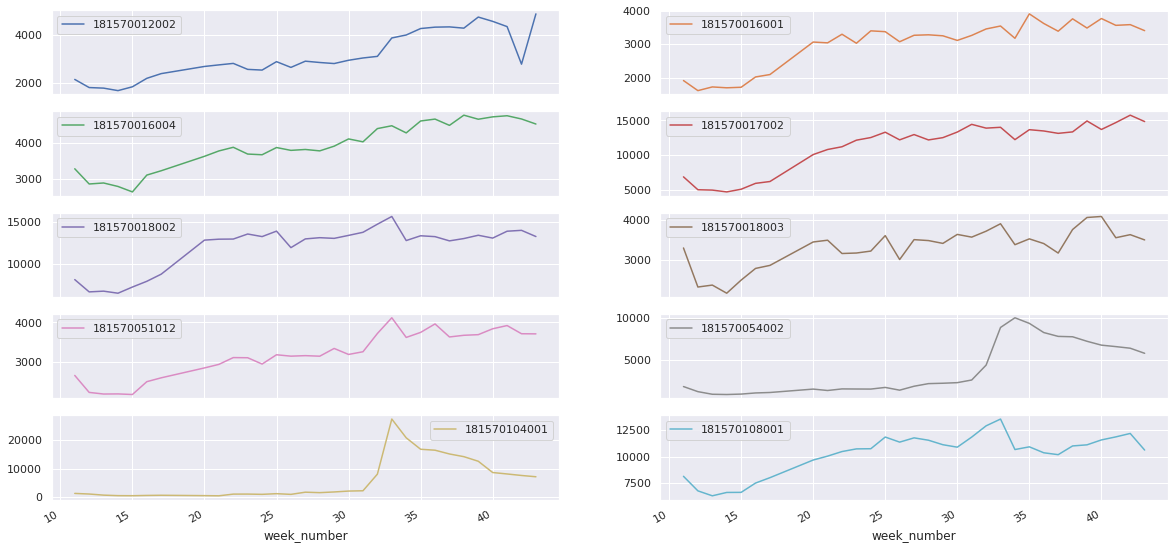

In [55]:
df2 = df.groupby('poi_cbg')['raw_visit_counts'].sum().sort_values(ascending=False)
# df1 = df1.reset_index()
df2 = df2.iloc[:10]
top_cbg = df[df['poi_cbg'].isin(df2.index)]
p = top_cbg.groupby(['poi_cbg', 'week_number'])['raw_visit_counts'].sum().unstack('poi_cbg').plot(figsize=(20, 10), subplots = True, layout=(5,2))

### Trend of Visits by Place Category (Top 12 categories)
The graph below shows the total number of visits by top 12 categories through the weeks. From the graph we can see that there is a huge spike in some of the categories from week 30 to 33 and a decline after week 33. This is caused by the startinf of Purdue's fall semester. Essential categories such as automotive, health, physicials, dentists are not affected by Purdue's semester start.

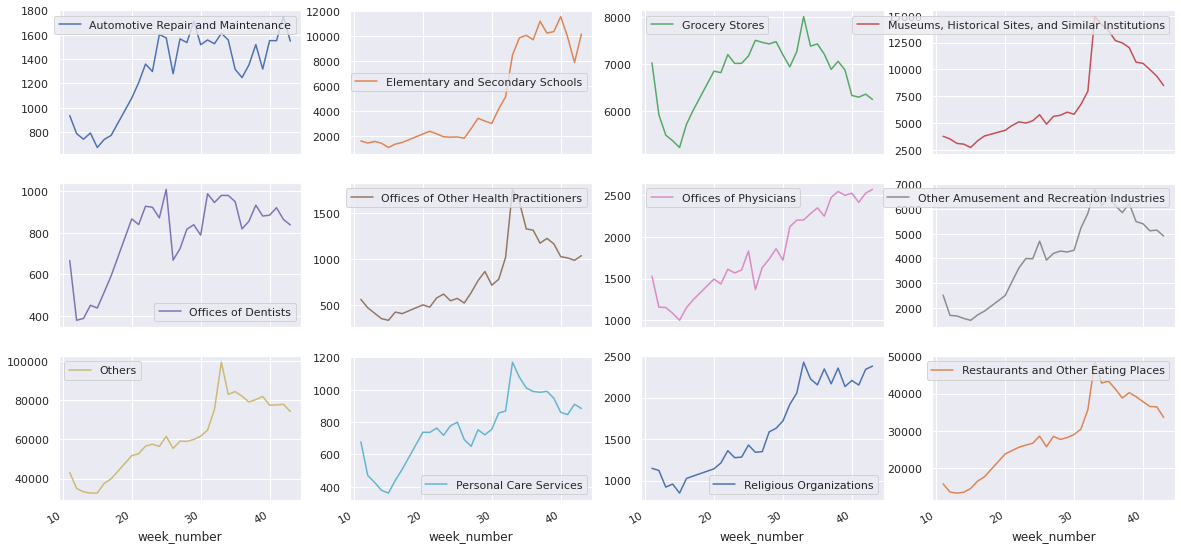

In [32]:
df1 = df.groupby('top_category')['top_category'].count().sort_values(ascending=False)
# df1 = df1.reset_index()
df1 = df1.iloc[:12]
cat = df[df['top_category'].isin(df1.index)]
c = cat.groupby(['top_category', 'week_number'])['raw_visit_counts'].sum().unstack('top_category').plot(figsize=(20, 10), subplots = True, layout=(3,4))

### Trend of Visits Concentrations by Place Category (Top 12 categories)
The graph below shows the total number of visits concentrations splited by top 12 categories through the weeks. Form this, we can see that visit concentrations for categories such as elementary schools, physicians, religious organizations, restaurants, and recreation industries has been decreasing due to the covid.

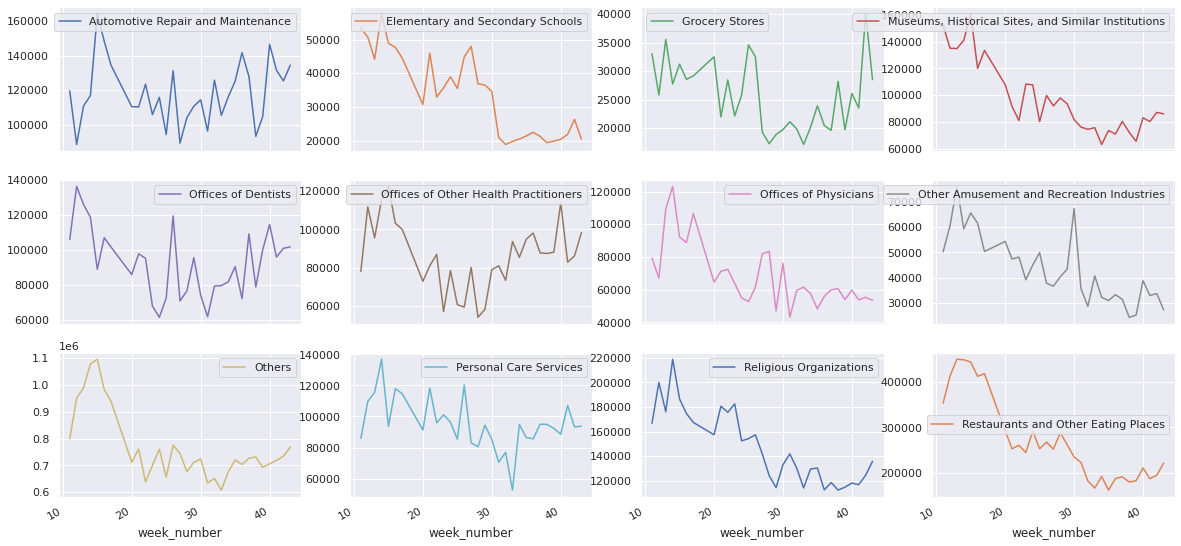

In [33]:
p = cat.groupby(['top_category', 'week_number'])['visits_concentration'].sum().unstack('top_category').plot(figsize=(20, 10), subplots = True, layout=(3,4))

### Trend of Visits by Postal Code
These graphs below shows the totoal visits splited by postal codes. We can see that different postal codes have drastically different pattern for number of visitors througout the period. We can tell that the postal codes 47906 and 47907 are where Purdue is judging from their trend.

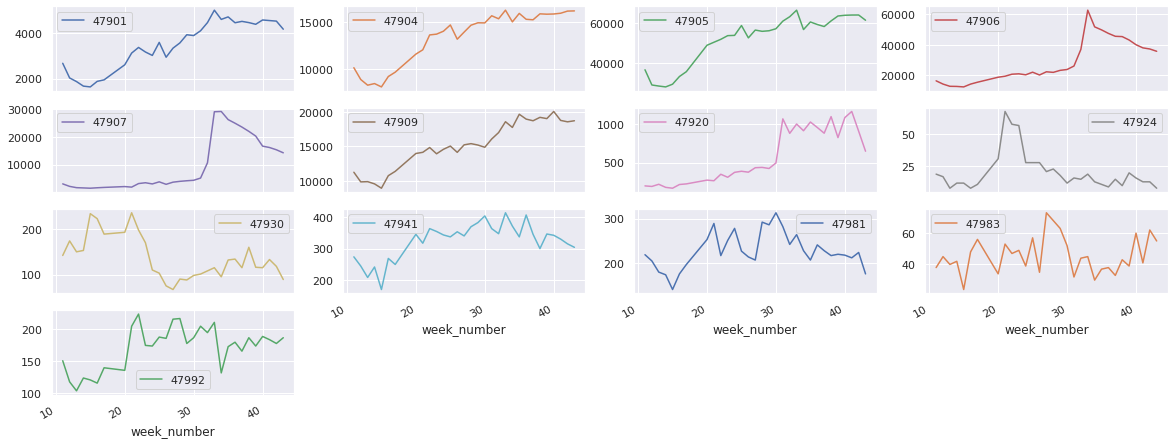

In [35]:
p = df.groupby(['postal_code', 'week_number'])['raw_visit_counts'].sum().unstack('postal_code').plot(figsize=(20, 10), subplots = True, layout=(5,4))

### Trend of Visits Concentrations by Postal Code
These graphs below shows the visits concentrations splited by postal codes. We can see that different postal codes have drastically different pattern for visits concentrations througout the period.

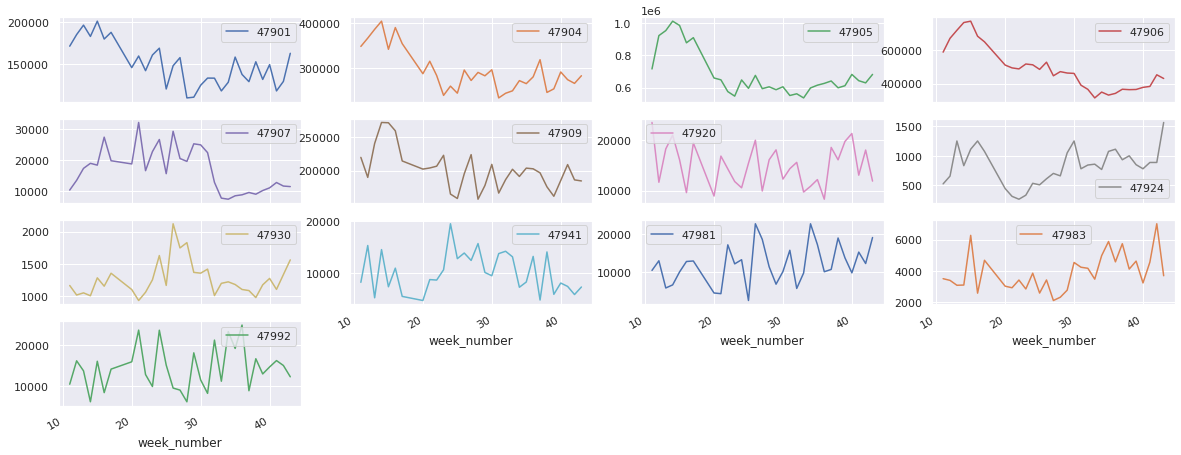

In [36]:
p = df.groupby(['postal_code', 'week_number'])['visits_concentration'].sum().unstack('postal_code').plot(figsize=(20, 10), subplots = True, layout=(5,4))

### Campare Raw Visit Counts Throughout the Weeks on Map
The graph below shows the change in visitor numbers as weeks goes on. I zoomed in on Lafayette  and West Lafayette part so that the places are easier to see. We can see that over all, the amount fo visitors has increases. Especially for Purdue area, the visitors increased a lot since the school started.

In [27]:
df1 = df.groupby('top_category')['top_category'].count().sort_values(ascending=False)
# df1 = df1.reset_index()
df1 = df1.iloc[:5]
top_cat = df[df['top_category'].isin(df1.index)]
df.loc[~df["top_category"].isin(top_cat['top_category']), "top_category"] = "Others"
wk43 = df[df['week_number']==43]
wk = df[df['week_number'].isin([11,21,31,41])]
wk43['top_category']=wk43['top_category'].replace('Restaurants and Other Eating Places', 'Restaurants').replace('Museums, Historical Sites, and Similar Institutions', 'Museums').replace('Religious Organizations', 'Religious').replace('Automotive Repair and Maintenance', 'Auto Repair').replace('Other Amusement and Recreation Industries', 'Recreation')
top = ('Restaurants', 'Museums','Religious','Auto Repair', 'Recreation','Others')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Places on the Map

### Location on Map with Visit Counts and Top Category for Week 43
For the graph below, I ploted the places with matching latitude and longitde for week 43. The different colors represent different categories and the sizes represents the number of visitores for that week. Since the difference between the visitors for places are very big, I averaged them out abit so that the graph shows as much place as possible.

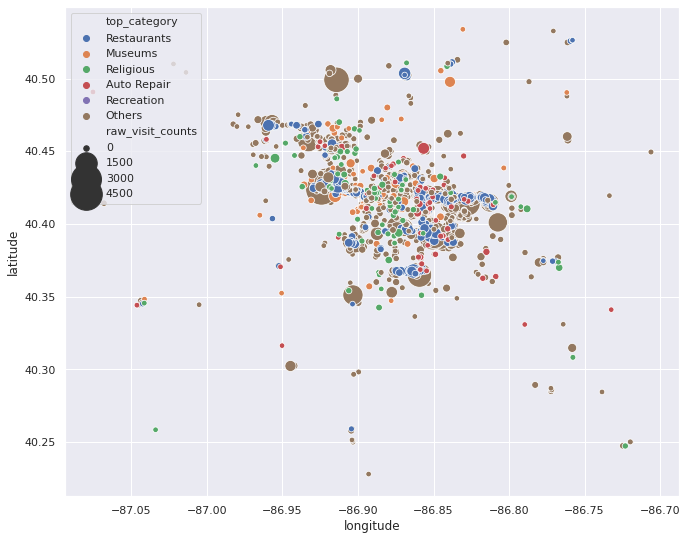

In [30]:
figure = sns.scatterplot('longitude', 'latitude', data=wk43, size ="raw_visit_counts", sizes=(30, 1000), hue="top_category", hue_order = top)

sns.set(rc={'figure.figsize':(11,9)})
plt.show()

### Campare Raw Visit Counts Throughout the Weeks on Map
The graph below shows the change in visitor numbers as weeks goes on. I zoomed in on Lafayette  and West Lafayette part so that the places are easier to see. We can see that over all, the amount fo visitors has increases. Especially for Purdue area, the visitors increased a lot since the school started.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

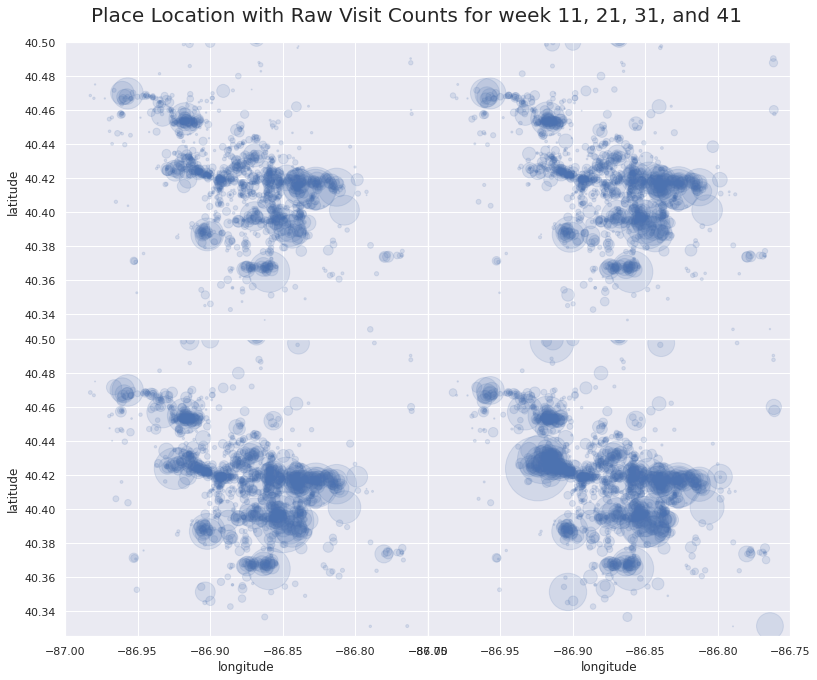

In [56]:
table = pd.pivot_table(wk, values='raw_visit_counts', columns='week_number', index=["latitude",'longitude'], fill_value=0)
table = table.reset_index()

fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
    
table.plot(kind='scatter',ax=axes[0,0], x="longitude", y="latitude", s=table.iloc[:,2], alpha=0.15, figsize=(13,10), xlim = (-87,-86.75), ylim = (40.325,40.5))
table.plot(kind='scatter',ax=axes[0,1], x="longitude", y="latitude", s=table.iloc[:,3], alpha=0.15, xlim = (-87,-86.75), ylim = (40.325,40.5))
table.plot(kind='scatter',ax=axes[1,0], x="longitude", y="latitude", s=table.iloc[:,4], alpha=0.15, xlim = (-87,-86.75), ylim = (40.325,40.5))
table.plot(kind='scatter',ax=axes[1,1], x="longitude", y="latitude", s=table.iloc[:,5], alpha=0.15, xlim = (-87,-86.75), ylim = (40.325,40.5))

fig.suptitle('Place Location with Raw Visit Counts for week 11, 21, 31, and 41',fontsize=20, y=1)
fig.subplots_adjust(wspace=0,hspace=0, top=0.95)

# Conclsion
From the data I could tell that the peak for the number of visits are the weeks leading to Purdue's fall semester start. After school started, the number of visits started to decrease. So I'd advise to take precausion 1 to 2 weeks prior to school starting this spring semester, because that is when there will be the most visit counts.